In [5]:
import math

In [6]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [7]:
from graphviz import Digraph

In [8]:
from graphviz import Digraph
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{  %s| data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot

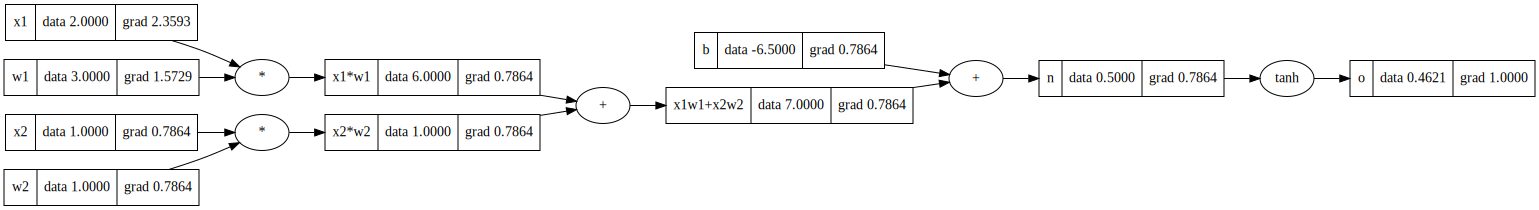

In [9]:
x1=Value(2.0,label='x1')
x2=Value(1.0,label='x2')
w1 =Value(3.0,label='w1')
w2= Value(1.0,label='w2')
b= Value(-6.50,label='b')
x1w1= x1*w1
x1w1.label ="x1*w1"
x2w2=x2*w2;x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2;x1w1x2w2.label='x1w1+x2w2'
n=x1w1x2w2+b;n.label='n'

# e = (2*n).exp();e.label="e"
# o=(e-1)/(e+1)
o=n.tanh()
o.label='o'
o.backward()
draw_dot(o)


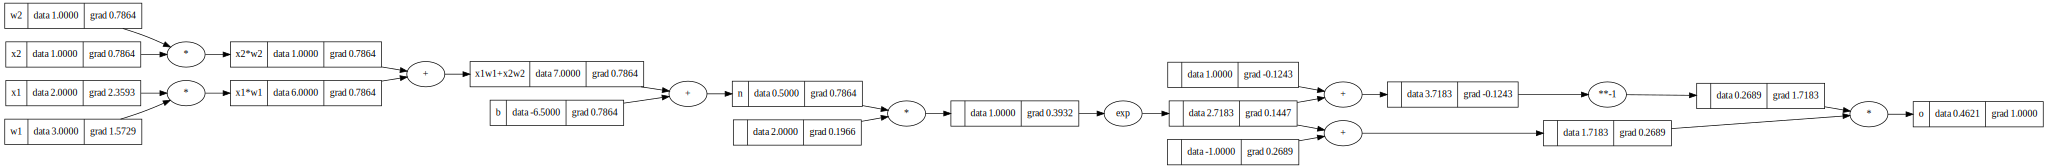

In [10]:
x1=Value(2.0,label='x1')
x2=Value(1.0,label='x2')
w1 =Value(3.0,label='w1')
w2= Value(1.0,label='w2')
b= Value(-6.50,label='b')
x1w1= x1*w1
x1w1.label ="x1*w1"
x2w2=x2*w2;x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2;x1w1x2w2.label='x1w1+x2w2'
n=x1w1x2w2+b;n.label='n'

e = (2*n).exp()
o=(e-1)/(e+1)
# o=n.tanh()
o.label='o'
o.backward()
draw_dot(o)


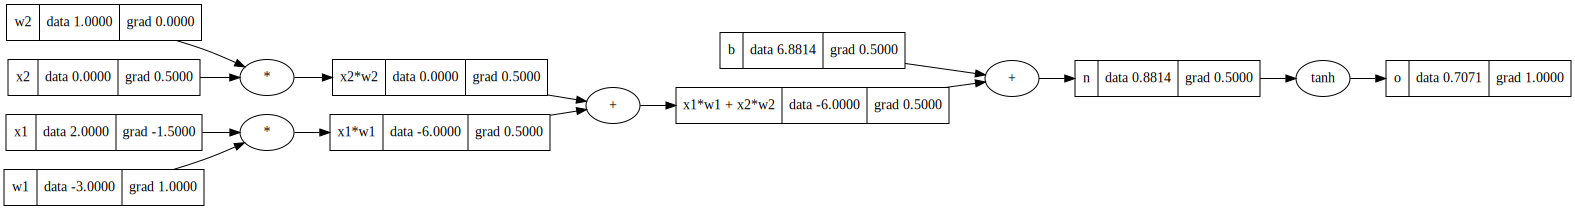

In [11]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

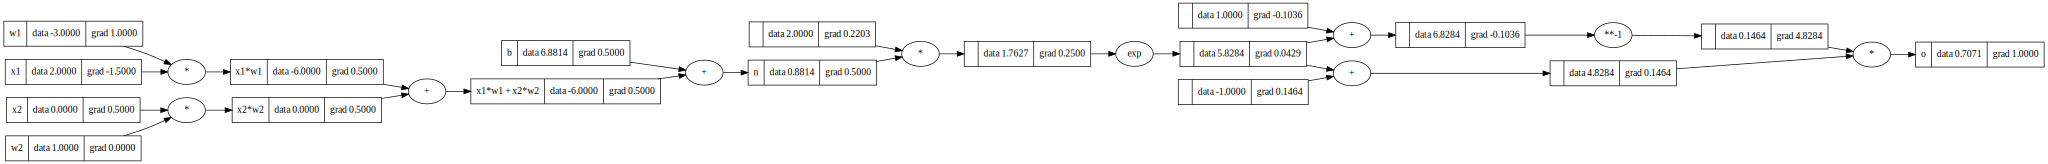

In [12]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o=(e-1)/(e+1)
# o=n.tanh()
o.label='o'
o.backward()
draw_dot(o)

In [13]:
import  random

In [14]:
class Neuron:
    def __init__(self,nin):
        self .w  =  [Value(random.uniform(-1,1))for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        act =  sum(wi*xi for wi,xi in zip(self.w,x))
        out = act.tanh()
        return  out
    def params(self):
        return self.w  +[self.b]

In [15]:
neu = Neuron(2)

In [16]:
x=[1.0,2.0]

In [17]:
 neu(x)

Value(data=0.9856122585276982)

In [18]:
class Layer:
    def __init__(self,nin,nout):
        self.neuron  = [Neuron(nin) for _ in  range(nout)]
    def __call__(self,x):
        out  =  [n(x) for  n in self.neuron]
        if(len(out)==1):
            return out[0]
        else:
            return  out
    def parameters(self):
        param =[]
        for  p in  self.neuron:
        
            param.extend(p.params())
        return param

In [19]:
l=Layer(2,4)

In [20]:
l(x)

[Value(data=-0.901612455144705),
 Value(data=-0.8311003707998627),
 Value(data=-0.965993388023766),
 Value(data=-0.6305736788801565)]

In [21]:
class  MLP:
    def __init__(self,nin,nout):
        sz = [nin]+nout
        self.layes = [Layer(sz[i],sz[i+1]) for  i in  range(len(nout))]
    def __call__(self,x):
        for  layerss in  self.layes:
            x= layerss(x)
        return x
    def parameters(self):
        param=[]
        for p in self.layes:
           
            param.extend(p.parameters())
        return param
            
        
        

In [22]:
mlp_obj =MLP(3,[3,4,1])

In [23]:
mlp_obj(x)

Value(data=-0.6839411794887261)

In [24]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired target


In [25]:
y_pred  = [mlp_obj(a) for a  in xs]

In [26]:
y_pred

[Value(data=-0.6481361885860302),
 Value(data=-0.4409193741132519),
 Value(data=-0.5637191430316051),
 Value(data=-0.6788978398898617)]

In [34]:

for k in range(100):
  
  # forward pass
  y_pred = [mlp_obj(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))
  
  # backward pass
  for p in mlp_obj.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in mlp_obj.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 0.002608056434540192
1 0.0025824386848010044
2 0.002557306395951281
3 0.0025326460497616292
4 0.002508444622134593
5 0.002484689560825234
6 0.002461368764352689
7 0.0024384705620294385
8 0.0024159836950400147
9 0.0023938972985050864
10 0.0023722008844721206
11 0.002350884325777284
12 0.002329937840726911
13 0.002309351978550649
14 0.0022891176055814012
15 0.0022692258921200295
16 0.002249668299945779
17 0.002230436570435709
18 0.002211522713258819
19 0.0021929189956128485
20 0.0021746179319735597
21 0.002156612274328386
22 0.0021388950028680452
23 0.0021214593171111967
24 0.0021042986274390075
25 0.0020874065470176486
26 0.0020707768840882686
27 0.0020544036346049777
28 0.002038280975202954
29 0.0020224032564793142
30 0.0020067649965707967
31 0.0019913608750129893
32 0.0019761857268671573
33 0.001961234537100692
34 0.0019465024352089875
35 0.0019319846900664516
36 0.0019176767049955278
37 0.0019035740130429748
38 0.0018896722724534062
39 0.0018759672623304437
40 0.0018624548784766568

In [35]:
y_pred

[Value(data=0.9828428546195831),
 Value(data=-0.9843209816284405),
 Value(data=-0.9774304904390725),
 Value(data=0.9840661452714181)]